## Packages

In [1]:
import numpy as np
import os
import pandas as pd
import time
from pathlib import Path
from datetime import datetime
from PIL import Image
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.optim as optim
import torchvision
import torchvision.models
import torchvision.transforms as transforms
from torch.optim import SGD, Adam, AdamW
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader, Dataset
from torch.utils.tensorboard import SummaryWriter
from torchvision.datasets import DatasetFolder, ImageFolder
from tqdm import tqdm
from sklearn import model_selection
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score, \
accuracy_score
from avalanche.models import SlimResNet18, MTSlimResNet18, SimpleCNN
from avalanche.models import as_multitask, IncrementalClassifier
from avalanche.models.utils import avalanche_model_adaptation
from avalanche.training import Naive, LwF, GenerativeReplay, ICaRLLossPlugin, ICaRL, EWC, AR1, LFL, AGEM, DER
from avalanche.logging import (
    InteractiveLogger,
    TextLogger,
    CSVLogger,
)
from avalanche.training.plugins import EvaluationPlugin, ReplayPlugin, LwFPlugin, EarlyStoppingPlugin, AGEMPlugin
from avalanche.training.plugins.lr_scheduling import LRSchedulerPlugin
from avalanche.benchmarks import nc_benchmark, ni_benchmark
from avalanche.benchmarks.utils import AvalancheDataset
from avalanche.benchmarks.scenarios.dataset_scenario import benchmark_from_datasets
from avalanche.benchmarks.scenarios.supervised import class_incremental_benchmark
from avalanche.evaluation.metrics import forgetting_metrics, accuracy_metrics,loss_metrics, \
timing_metrics, cpu_usage_metrics, StreamConfusionMatrix, disk_usage_metrics, gpu_usage_metrics, \
confusion_matrix_metrics, bwt_metrics, forward_transfer_metrics, ram_usage_metrics, images_samples_metrics
from avalanche.evaluation.metrics import Accuracy, BWT, Forgetting, ForwardTransfer
import multiprocessing as mp
import my_utils
import my_architectures
import my_dataloaders
# import my_gwpy_and_fractals
import my_transformations
IMG_SIZE = (224,224)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

D:\Users\Brian\MscThesis_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# calculating the amount of workers usable
number_of_workers = mp.cpu_count()
number_of_workers = int(number_of_workers-2)
print(number_of_workers)

10


In [3]:
# Setting the correct directories
train_dir = 'D:\\Users\\Brian\\TrainingSet_CL_1\\TrainingSet_CL_1'
#train_dir = 'C:\\Users\\Brian.Baert\\TrainingSet_CL_1'
train_dir_2 = 'D:\\Users\Brian\\TrainingSet_CL_2\\TrainingSet_CL_2'
#train_dir_2 = 'C:\\Users\\Brian.Baert\\TrainingSet_CL_2'
val_dir = 'D:\\Users\\Brian\\TestSet_CL\\TestSet_CL'
#val_dir = 'C:\\Users\\Brian.Baert\\ValidationSet_CL'
test_dir = 'D:\\Users\\Brian\\TestSet_CL\\TestSet_CL'
#test_dir = 'C:\\Users\\Brian.Baert\\TestSet_CL'

# Read in class labels
class_file = open("classes.txt", "r")
classes = class_file.read()
classes = classes.split(", ")

## MultiView Fusion Naive model

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = my_architectures.MultiViewColorNet_resnet18(num_classes=10)
model.to(device)
# log to text file
text_logger = TextLogger(open("multiview_fusion_naive_log_100epochs.txt", "a"))
# print to stdout
interactive_logger = InteractiveLogger()
csv_logger = CSVLogger()
classes = my_utils.get_classes_from_dir(train_dir_2)
class_to_indx = my_utils.classes_to_indices(classes)

In [5]:
print(classes)

['Blip', 'Blip_Low_Frequency', 'Extremely_Loud', 'Fast_Scattering', 'Koi_Fish', 'Low_Frequency_Burst', 'Low_Frequency_Lines', 'Scattered_Light', 'Tomte', 'Whistle']


In [6]:
train_set = my_dataloaders.MultiViewGravitySpyDataset(root=train_dir, cls=classes, transform=my_transformations.transformAV_Fuse_448_Crop)
val_set = my_dataloaders.MultiViewGravitySpyDataset(root=val_dir, cls=classes, transform=my_transformations.transformAV_448_Fuse)
test_set = my_dataloaders.MultiViewGravitySpyDataset(root=test_dir, cls=classes, transform=my_transformations.transformAV_448_Fuse)

train_set_av = AvalancheDataset(train_set)
train_loader_av = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True, num_workers=number_of_workers)

val_set_av = AvalancheDataset(val_set)
val_loader_av = torch.utils.data.DataLoader(val_set, batch_size=32, shuffle=True, num_workers=number_of_workers)

test_set_av = AvalancheDataset(test_set)
test_loader_av = torch.utils.data.DataLoader(test_set, batch_size=1, shuffle=True)

train_set_av.targets = [label for i, label in enumerate(train_set.labels) if i % 4 == 0]
test_set_av.targets = [label for i, label in enumerate(test_set.labels) if i % 4 == 0]
val_set_av.targets = [label for i, label in enumerate(val_set.labels) if i % 4 == 0]

train_set_av.uniques = list(set(train_set.labels))
test_set_av.uniques = list(set(test_set.labels))
val_set_av.uniques = list(set(val_set.labels))

In [ ]:
# Get the first batch from the dataloader
batch = next(iter(train_set))

# Extract the first image and its label (if available)
image, label = batch

In [ ]:
image.shape

In [ ]:
label

In [ ]:
# Convert image tensor to numpy array
image_np = image.numpy().transpose((1, 2, 0)) #need to transpose to (H, W, C) format
# Create a subplot and display the image
plt.figure(figsize=(8,8))
plt.imshow(image_np)
plt.axis('off')  # Hide axes
plt.title(f"Label: {label}") if label is not None else plt.title("First Image")
plt.show()

In [7]:
bm = nc_benchmark(
    train_dataset=train_set_av,
    test_dataset=val_set_av,
    n_experiences=5,
    shuffle=True,
    seed=1234,
    task_labels=False,
    class_ids_from_zero_in_each_exp=False,
)

In [8]:
eval_plugin = EvaluationPlugin(
    accuracy_metrics(minibatch=False, epoch=True, experience=True, stream=True),
    loss_metrics(minibatch=False, epoch=True, experience=True, stream=True),
    forgetting_metrics(experience=False, stream=True),
    ram_usage_metrics(experience=True, stream=True, epoch=False),
    bwt_metrics(experience=True, stream=True),
    loggers=[interactive_logger, text_logger, csv_logger],
    strict_checks=False,
)

In [9]:
# OPTIMIZER and CRITERION
optimizer = AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)
criterion = CrossEntropyLoss()

In [10]:
# NAIVE STRATEGY
cl_strategy = Naive(
    model=model, optimizer=optimizer, criterion=criterion, train_mb_size=32, train_epochs=100, 
    eval_mb_size=16, device=device, evaluator=eval_plugin, 
    plugins=[ReplayPlugin(mem_size=2*len(train_set)), EarlyStoppingPlugin(patience=2, val_stream_name='train')]
)

Starting experiment with strategy: <avalanche.training.supervised.strategy_wrappers.Naive object at 0x000001D16426C2B0>
Start of experience:  0
Current Classes:  [4, 5]
-- >> Start of training phase << --
100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:22<00:00,  1.76s/it]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.9920
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.8925
100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:21<00:00,  1.66s/it]
Epoch 1 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0727
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9975
100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:21<00:00,  1.67s/it]
Epoch 2 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0164
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9975
100%|█████████████████████████████████████████████████

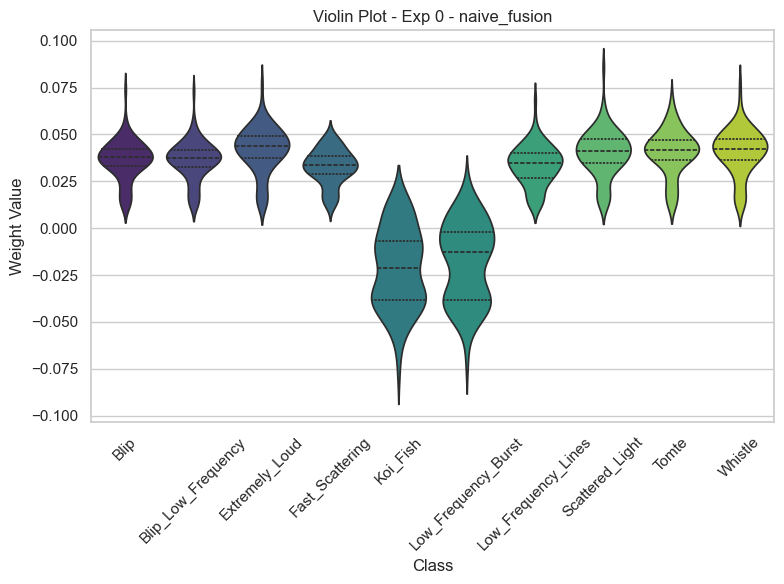

Start of experience:  1
Current Classes:  [8, 2]
-- >> Start of training phase << --
100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:41<00:00,  3.20s/it]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 2.7165
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.4500
100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:40<00:00,  3.13s/it]
Epoch 1 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 1.1816
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.4975
100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:41<00:00,  3.20s/it]
Epoch 2 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.8357
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.6225
100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:40<00:00,  3.15s/it]
Epoch 3 ended.
	Loss_Epoch/train_phase/train_stream/Ta

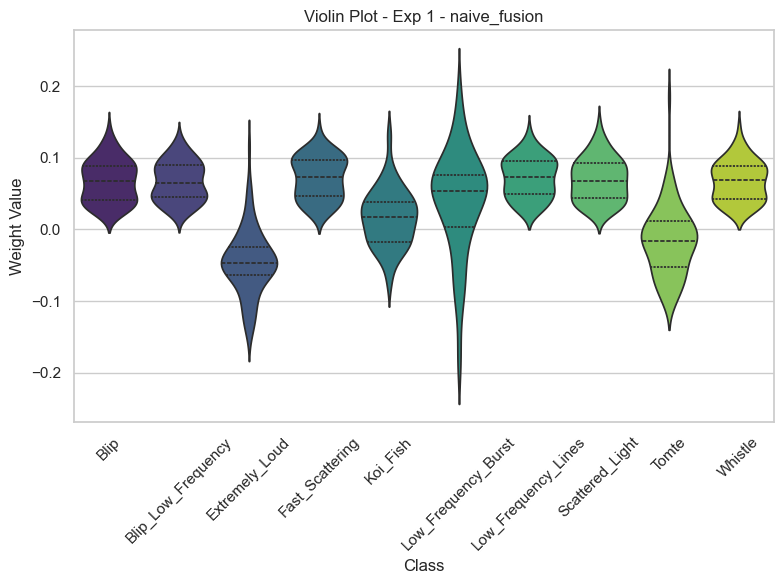

Start of experience:  2
Current Classes:  [9, 6]
-- >> Start of training phase << --
100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:43<00:00,  3.34s/it]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 2.4204
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.4694
100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:42<00:00,  3.29s/it]
Epoch 1 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 1.0220
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.5294
100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:42<00:00,  3.29s/it]
Epoch 2 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.8328
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.6127
100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:42<00:00,  3.29s/it]
Epoch 3 ended.
	Loss_Epoch/train_phase/train_stream/Ta

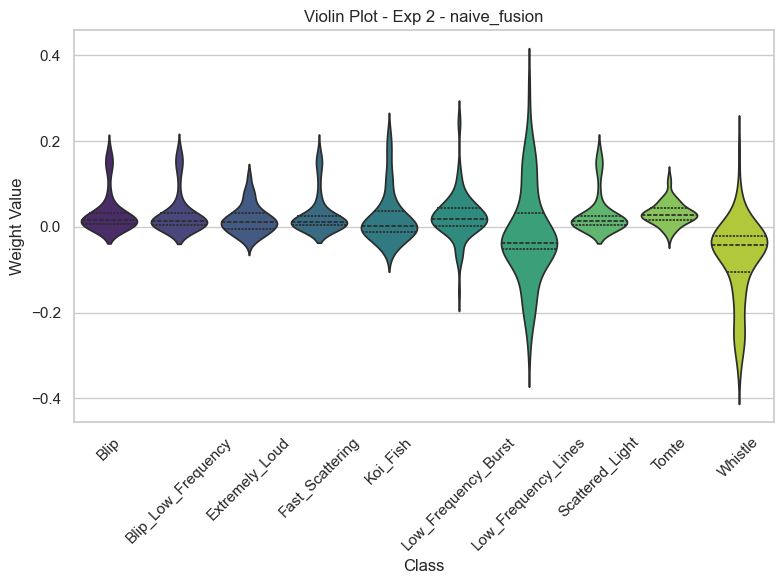

Start of experience:  3
Current Classes:  [1, 7]
-- >> Start of training phase << --
100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:52<00:00,  4.01s/it]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 4.0552
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.4277
100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:42<00:00,  3.26s/it]
Epoch 1 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 1.4174
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.5000
100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:42<00:00,  3.24s/it]
Epoch 2 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.6612
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.8346
100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:42<00:00,  3.29s/it]
Epoch 3 ended.
	Loss_Epoch/train_phase/train_stream/Ta

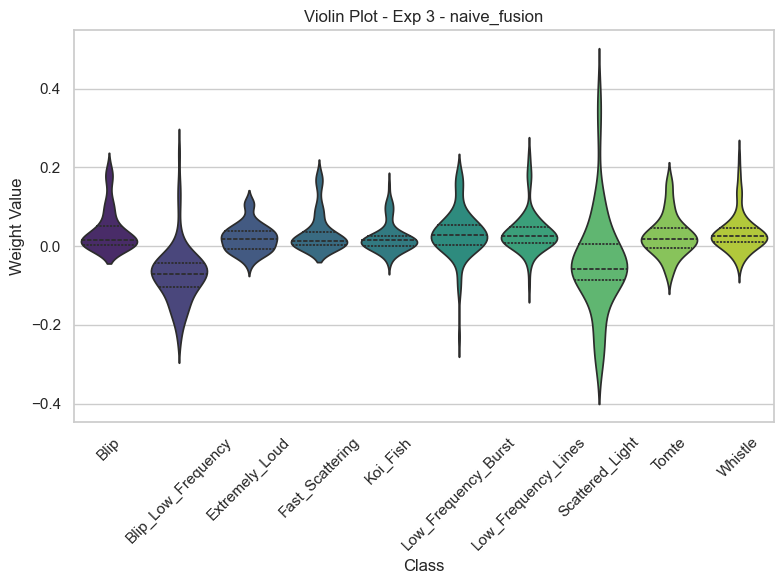

Start of experience:  4
Current Classes:  [0, 3]
-- >> Start of training phase << --
100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:51<00:00,  3.97s/it]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 4.6732
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.4179
100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:41<00:00,  3.20s/it]
Epoch 1 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 1.6985
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.3738
100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:41<00:00,  3.23s/it]
Epoch 2 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 1.3579
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.5123
100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:42<00:00,  3.25s/it]
Epoch 3 ended.
	Loss_Epoch/train_phase/train_stream/Ta

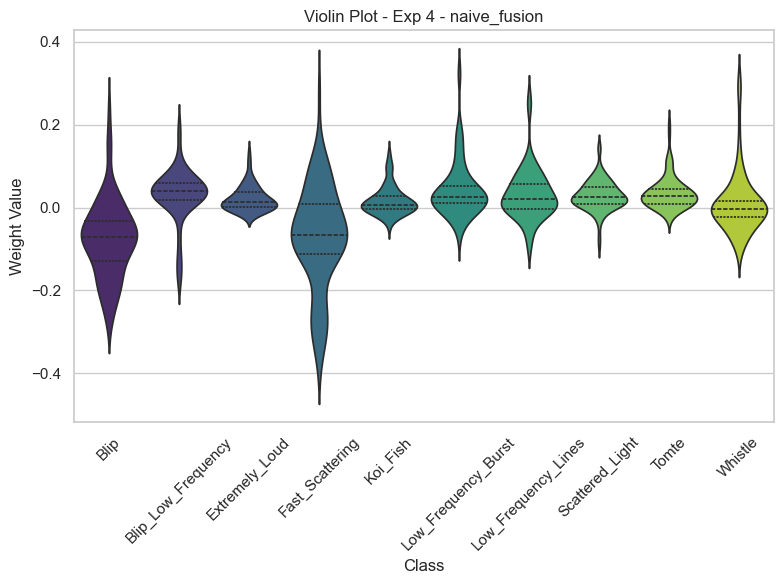

Stored metrics: ['Top1_Acc_Epoch/train_phase/train_stream/Task000', 'Loss_Epoch/train_phase/train_stream/Task000']
cl_simple_train_loop: 18913048.002004623 ms


In [11]:
# TRAINING
results=[]
results = my_utils.cl_simple_train_loop(bm, cl_strategy, model, optimizer, number_of_workers, classes, 'naive_fusion')

In [12]:
# SAVE MODEL
my_utils.checkpoint(model, 'Models/thesis_MultiView_Naive_CL_100epochs.pth')

Saved Pytorch model state to  Models/thesis_MultiView_Naive_CL_100epochs.pth


In [13]:
# LOAD MODEL
temp = torch.load('Models/thesis_MultiView_Naive_CL_100epochs.pth', map_location=torch.device(device))
model.load_state_dict(temp)

<All keys matched successfully>

In [14]:
# SOME TEST PREDICTIONS
my_utils.n_test_predictions(model, test_loader_av, classes, 20)

Predicted: "Koi_Fish", Actual: "Koi_Fish"
Predicted: "Extremely_Loud", Actual: "Extremely_Loud"
Predicted: "Low_Frequency_Lines", Actual: "Low_Frequency_Burst"
Predicted: "Low_Frequency_Lines", Actual: "Low_Frequency_Lines"
Predicted: "Blip", Actual: "Blip"
Predicted: "Fast_Scattering", Actual: "Fast_Scattering"
Predicted: "Blip_Low_Frequency", Actual: "Blip_Low_Frequency"
Predicted: "Low_Frequency_Burst", Actual: "Low_Frequency_Burst"
Predicted: "Koi_Fish", Actual: "Koi_Fish"
Predicted: "Blip_Low_Frequency", Actual: "Blip_Low_Frequency"
Predicted: "Fast_Scattering", Actual: "Fast_Scattering"
Predicted: "Low_Frequency_Lines", Actual: "Low_Frequency_Lines"
Predicted: "Whistle", Actual: "Whistle"
Predicted: "Blip", Actual: "Blip_Low_Frequency"
Predicted: "Low_Frequency_Lines", Actual: "Low_Frequency_Lines"
Predicted: "Blip", Actual: "Tomte"
Predicted: "Scattered_Light", Actual: "Scattered_Light"
Predicted: "Blip", Actual: "Blip"
Predicted: "Koi_Fish", Actual: "Koi_Fish"
Predicted: "Koi_F

In [15]:
# CALCULATE ALL PREDICTIONS
test_loader = torch.utils.data.DataLoader(test_set, batch_size=1, shuffle=True)
y_pred_list, y_true_list = my_utils.get_predictions(model, test_loader_av)

get_predictions: 65192.02136993408 ms


In [16]:
# GENERATE CONFUSION MATRIX AND F1
cm = confusion_matrix(y_true_list, y_pred_list)
f1 = f1_score(y_true_list, y_pred_list, average=None)

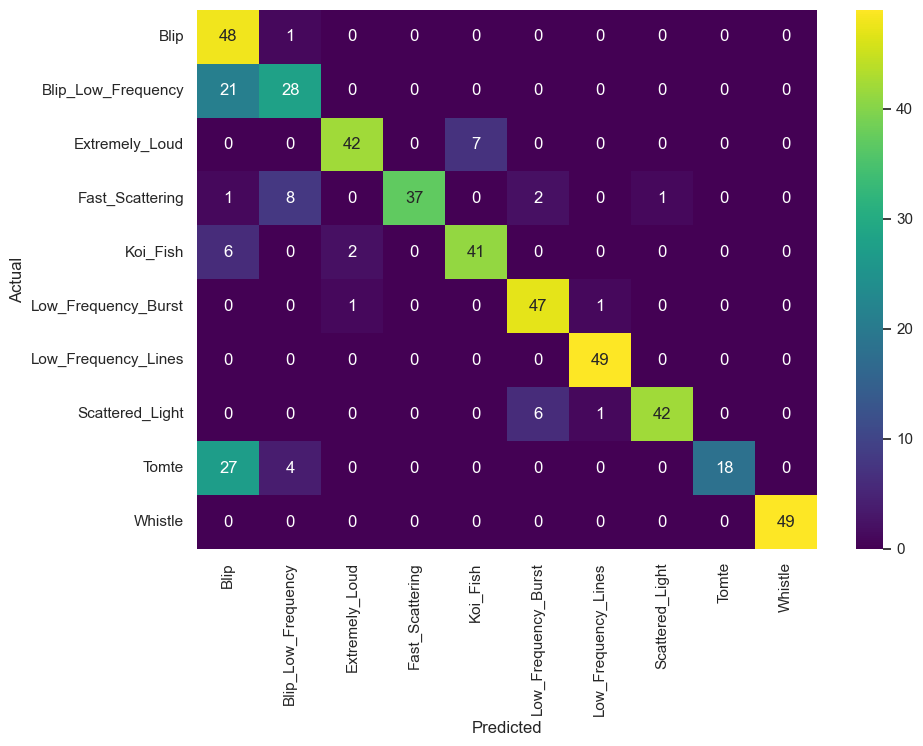

In [17]:
# PLOT CM
my_utils.plot_confusion_matrix(cm, classes, 'Results/cm_MultiView_Naive_100epochs.png')

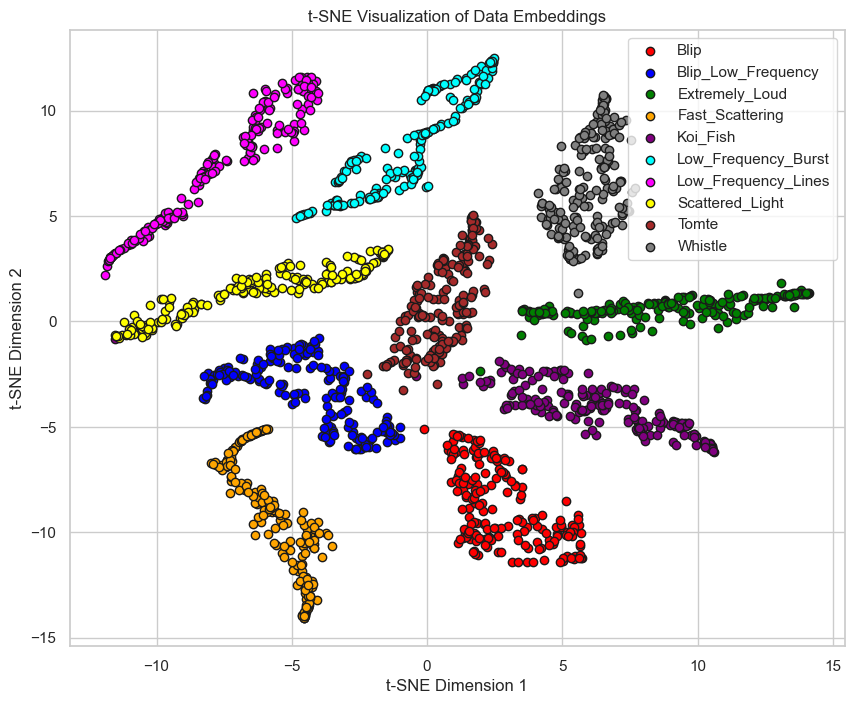

plot_tSNE_data_embedding: 90778.95188331604 ms


In [18]:
my_utils.plot_tSNE_data_embedding(model, train_loader_av, classes, 'Results/tSNE_MultiView_Naive_100epochs.png')

Real label = Fast_Scattering
Predicted label = Fast_Scattering


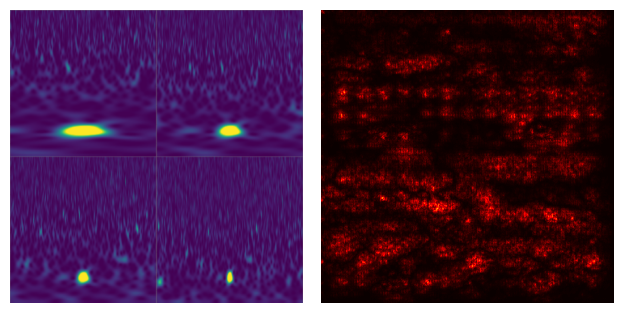

Real label = Low_Frequency_Lines
Predicted label = Low_Frequency_Lines


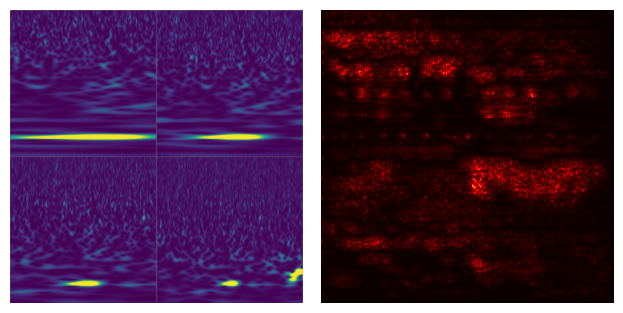

Real label = Koi_Fish
Predicted label = Koi_Fish


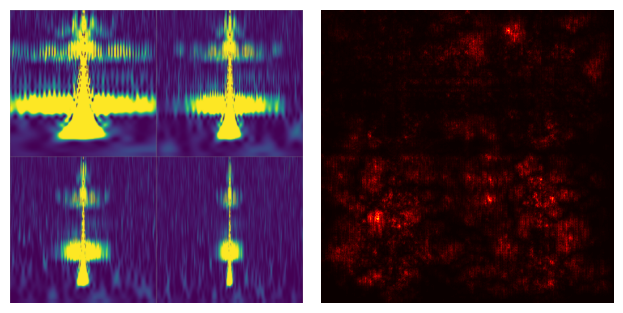

Real label = Blip_Low_Frequency
Predicted label = Blip_Low_Frequency


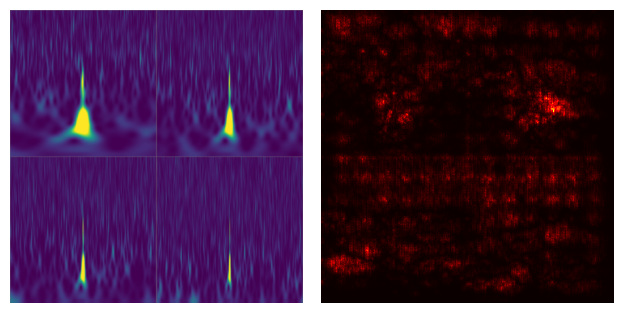

Real label = Extremely_Loud
Predicted label = Extremely_Loud


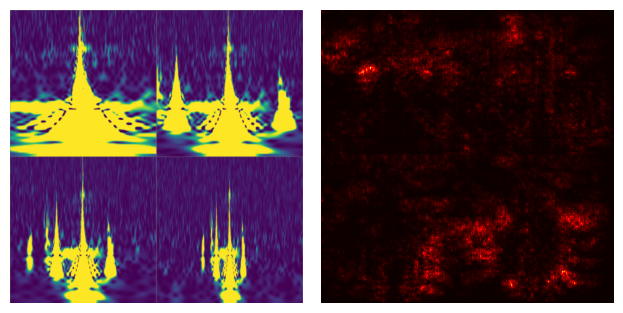

Real label = Fast_Scattering
Predicted label = Blip_Low_Frequency


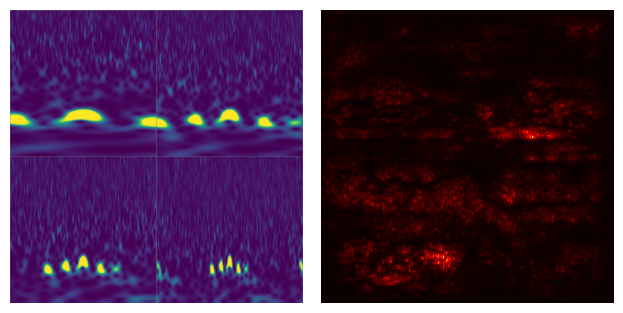

Real label = Extremely_Loud
Predicted label = Extremely_Loud


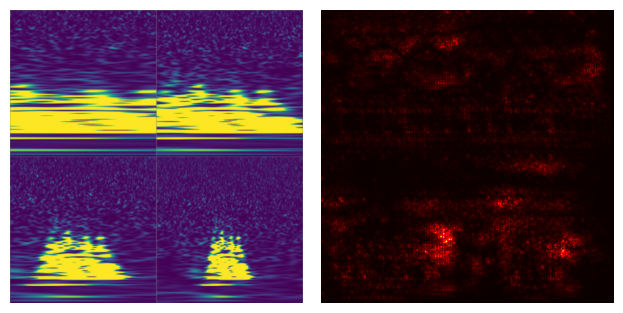

Real label = Extremely_Loud
Predicted label = Extremely_Loud


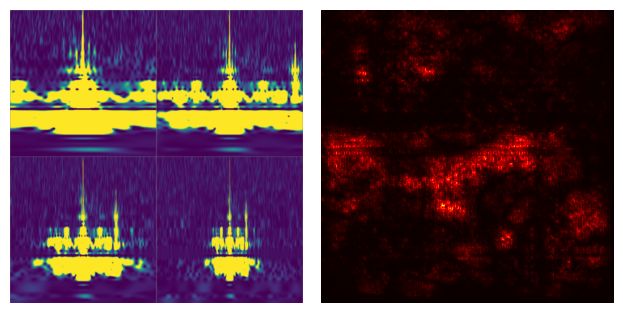

Real label = Low_Frequency_Lines
Predicted label = Low_Frequency_Lines


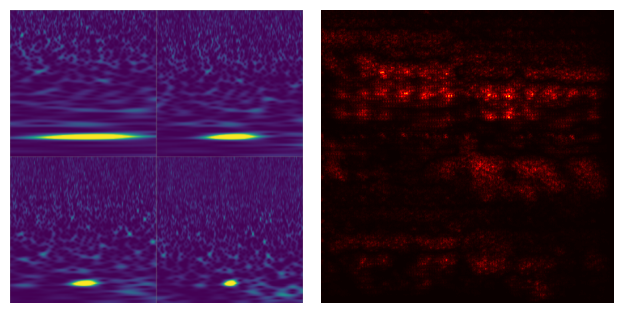

Real label = Low_Frequency_Burst
Predicted label = Low_Frequency_Burst


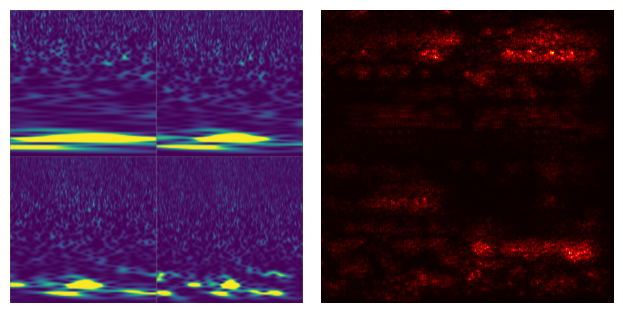

In [19]:
# SALIENCY MAP PLOT EXPERIMENT
# Get the first batch from the dataloader
i = 0
for image, label in test_loader_av:
    if i < 10:
        # Extract the first image and its label (if available)
        image, label = image.to(device), label.to(device)
        print(f"Real label = {classes[label]}")
        image.requires_grad_()
        # retrieve output from image 
        output = model(image)
        output_idx = output.argmax(dim=1)
        predicted_label = classes[output_idx.item()]
        print(f"Predicted label = {predicted_label}")
        output_max = output[0, output_idx]
        output_max.backward()
        saliency, _ = torch.max(image.grad.data.abs(), dim=1)
        fig, ax = plt.subplots(1, 2)
        ax[0].imshow(image[0].cpu().detach().numpy().transpose(1, 2, 0))
        ax[0].axis('off')
        ax[1].imshow(saliency[0].cpu().detach().numpy(), cmap='hot')
        ax[1].axis('off')
        plt.tight_layout()
        plt.show()
        i=i+1
    else:
        break

In [ ]:
def preprocess_image(image_path):
    # Open image as PIL image
    img = image_path  # Adjust size if needed
    # Normalize (if your model expects it)
    img = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(img)
    # Check for alpha channel (optional)
    if img.shape[1] == 3:  # If 3 channels, add dummy channel
        img = torch.cat([img, torch.ones_like(img[:, :, :1])], dim=2)
    return img.unsqueeze(0)

## Multiview Fusion LwF model

In [20]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = my_architectures.MultiViewColorNet_resnet18(num_classes=10)
model.to(device)
# log to text file
text_logger = TextLogger(open("multiview_fusion_LwF_log_100epochs.txt", "a"))
# print to stdout
interactive_logger = InteractiveLogger()
csv_logger = CSVLogger()
classes = my_utils.get_classes_from_dir(train_dir_2)
class_to_indx = my_utils.classes_to_indices(classes)

In [21]:
# OPTIMIZER and CRITERION
optimizer = AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)
criterion = CrossEntropyLoss()
#criterion = CrossEntropyLoss(weight=torch.tensor(class_weights, dtype=torch.float32), label_smoothing=0.2)

In [22]:
# STRATEGY 
# ALPHA AND TEMPERATURE are taken from the paper by Oren & Wolf - "In defense of the Learning Without Forgetting for Task Incremental Learning"
cl_strategy = LwF(
    model=model, optimizer=optimizer, criterion=criterion, alpha=0.25, temperature=2.0, 
    train_mb_size=64, train_epochs=100, eval_mb_size=32, device=device, evaluator=eval_plugin, 
    plugins=[ReplayPlugin(mem_size=2*len(train_set))] #Early stopping is not used here because LwF does not inherently support Early Stopping
)

Starting experiment with strategy: <avalanche.training.supervised.strategy_wrappers.LwF object at 0x000001D2E2BAE500>
Start of experience:  0
Current Classes:  [4, 5]
-- >> Start of training phase << --
100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:21<00:00,  3.13s/it]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 1.3845
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.7925
100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:20<00:00,  2.98s/it]
Epoch 1 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.4012
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9950
100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:20<00:00,  2.98s/it]
Epoch 2 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0618
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 1.0000
100%|███████████████████████████████████████████████████

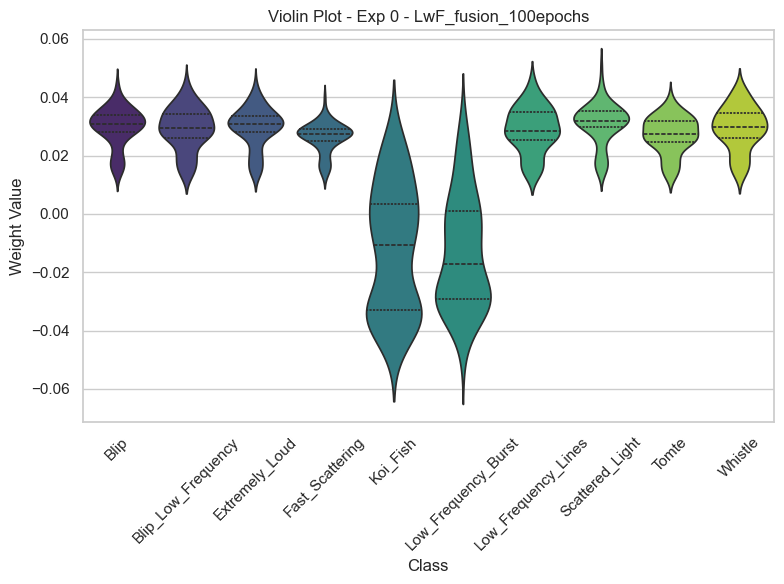

Start of experience:  1
Current Classes:  [8, 2]
-- >> Start of training phase << --
100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:40<00:00,  5.85s/it]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 4.0941
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.4688
100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:40<00:00,  5.85s/it]
Epoch 1 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 1.3528
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.6025
100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:40<00:00,  5.81s/it]
Epoch 2 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.8746
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.7688
100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:40<00:00,  5.82s/it]
Epoch 3 ended.
	Loss_Epoch/train_phase/train_stream/Ta

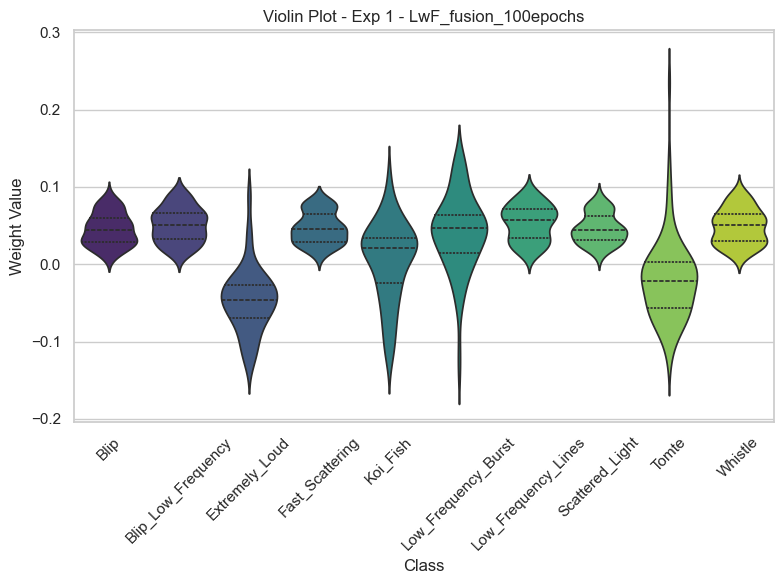

Start of experience:  2
Current Classes:  [9, 6]
-- >> Start of training phase << --
100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:44<00:00,  6.37s/it]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 3.4723
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.4481
100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:44<00:00,  6.36s/it]
Epoch 1 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 1.6091
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.4528
100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:44<00:00,  6.32s/it]
Epoch 2 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 1.3086
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.5035
100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:44<00:00,  6.31s/it]
Epoch 3 ended.
	Loss_Epoch/train_phase/train_stream/Ta

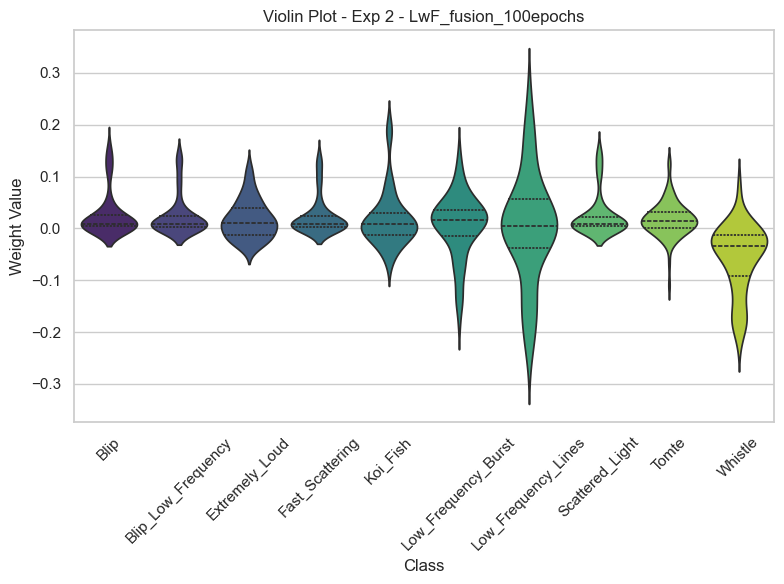

Start of experience:  3
Current Classes:  [1, 7]
-- >> Start of training phase << --
100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:44<00:00,  6.29s/it]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 4.4512
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.4752
100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:43<00:00,  6.28s/it]
Epoch 1 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 1.7621
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.4552
100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:43<00:00,  6.25s/it]
Epoch 2 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 1.4044
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.5295
100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:44<00:00,  6.34s/it]
Epoch 3 ended.
	Loss_Epoch/train_phase/train_stream/Ta

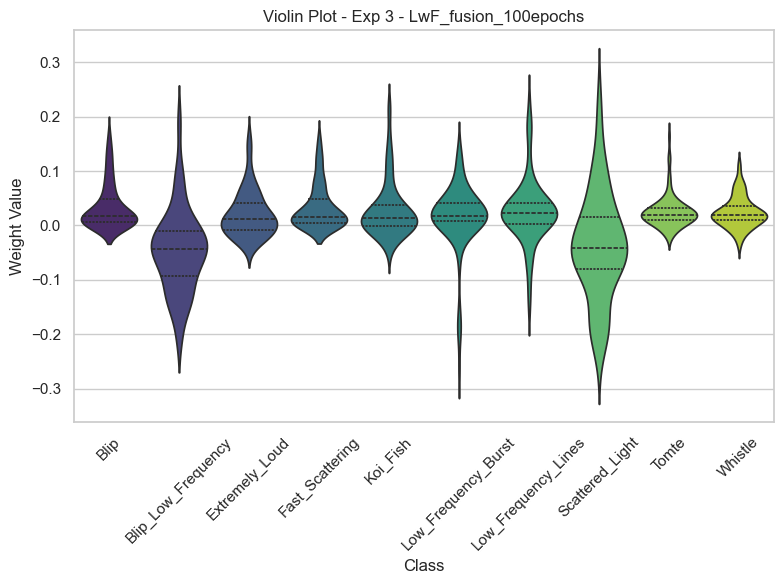

Start of experience:  4
Current Classes:  [0, 3]
-- >> Start of training phase << --
100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:44<00:00,  6.29s/it]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 5.2278
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.3939
100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:43<00:00,  6.23s/it]
Epoch 1 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 2.4334
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.2866
100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:43<00:00,  6.28s/it]
Epoch 2 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 2.1175
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.3809
100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:43<00:00,  6.19s/it]
Epoch 3 ended.
	Loss_Epoch/train_phase/train_stream/Ta

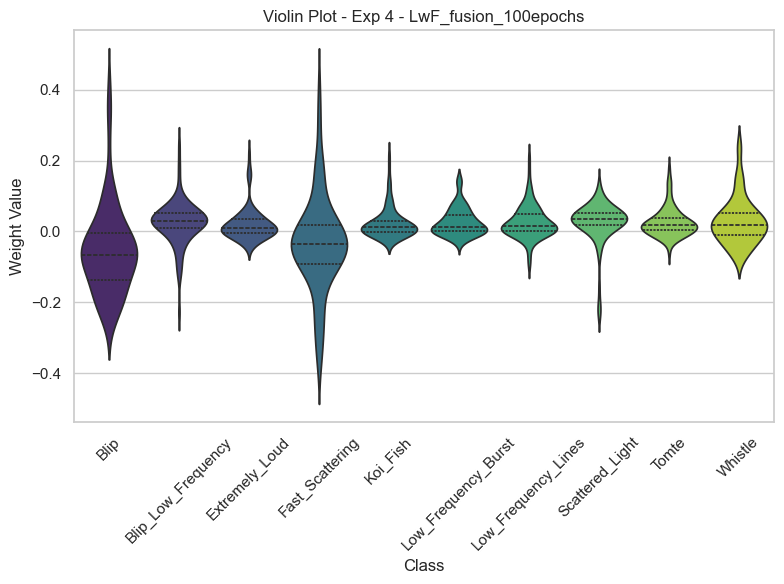

Stored metrics: ['Top1_Acc_Epoch/train_phase/train_stream/Task000', 'Loss_Epoch/train_phase/train_stream/Task000']
cl_simple_train_loop: 19343330.365419388 ms


In [23]:
# TRAINING
results=[]
results = my_utils.cl_simple_train_loop(bm, cl_strategy, model, optimizer, number_of_workers, classes, 'LwF_fusion_100epochs')

In [24]:
# SAVE MODEL
my_utils.checkpoint(model, 'Models/thesis_MultiView_LwF_100epochs.pth')

Saved Pytorch model state to  Models/thesis_MultiView_LwF_100epochs.pth


In [25]:
# CALCULATE ALL PREDICTIONS
test_loader = torch.utils.data.DataLoader(test_set, batch_size=1, shuffle=True)
y_pred_list, y_true_list = my_utils.get_predictions(model, test_loader_av)

get_predictions: 43143.237590789795 ms


In [26]:
# GENERATE CONFUSION MATRIX AND F1
cm = confusion_matrix(y_true_list, y_pred_list)
f1 = f1_score(y_true_list, y_pred_list, average=None)

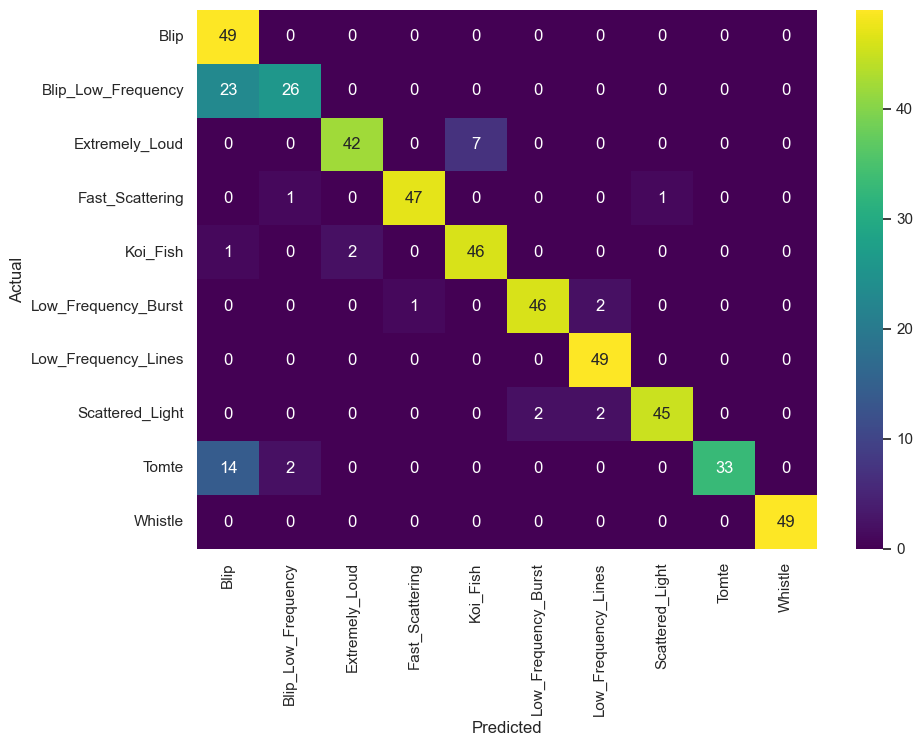

In [27]:
# PLOT CM
my_utils.plot_confusion_matrix(cm, classes, 'Results/cm_LwF_MultiView_100epochs.png')

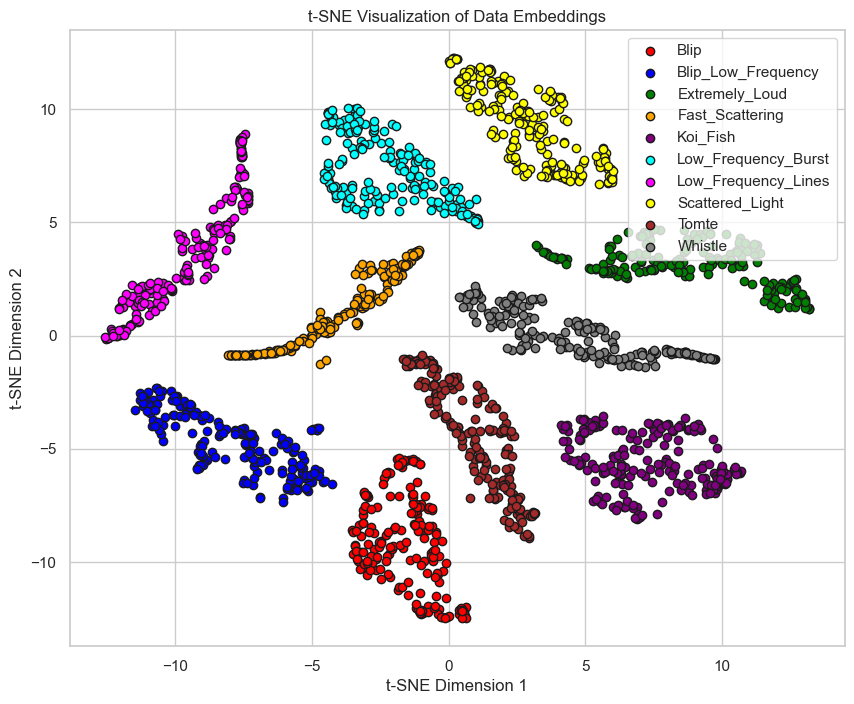

plot_tSNE_data_embedding: 83415.9746170044 ms


In [28]:
# PLOT t-SNE
my_utils.plot_tSNE_data_embedding(model, train_loader_av, classes, 'Results/tSNE_LwF_MultiView_100epochs.png')

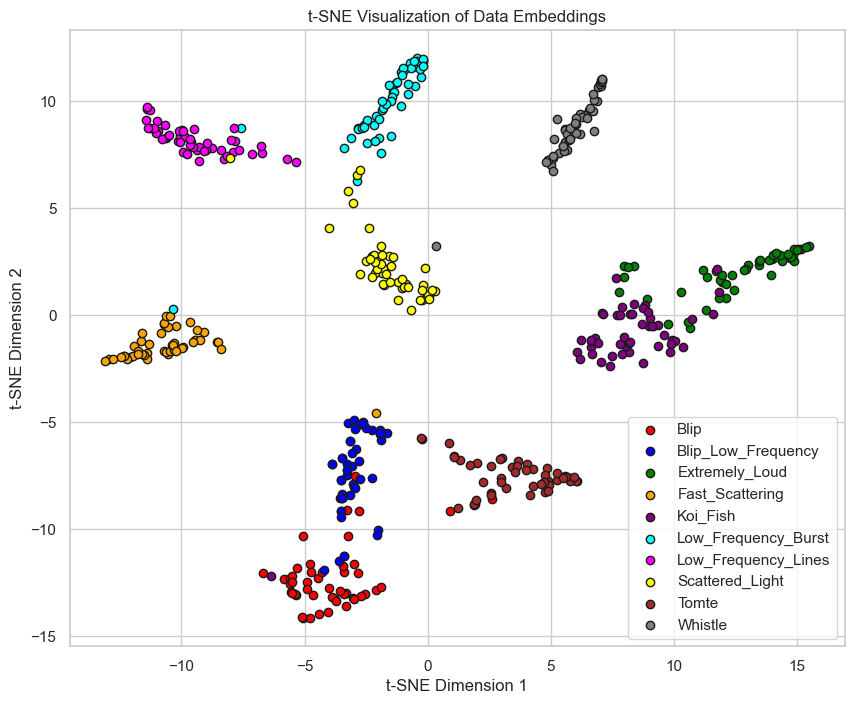

plot_tSNE_data_embedding: 52721.349239349365 ms


In [29]:
my_utils.plot_tSNE_data_embedding(model, test_loader_av, classes, 'Results/tSNE_LwF_MultiView_testset_100epochs.png')

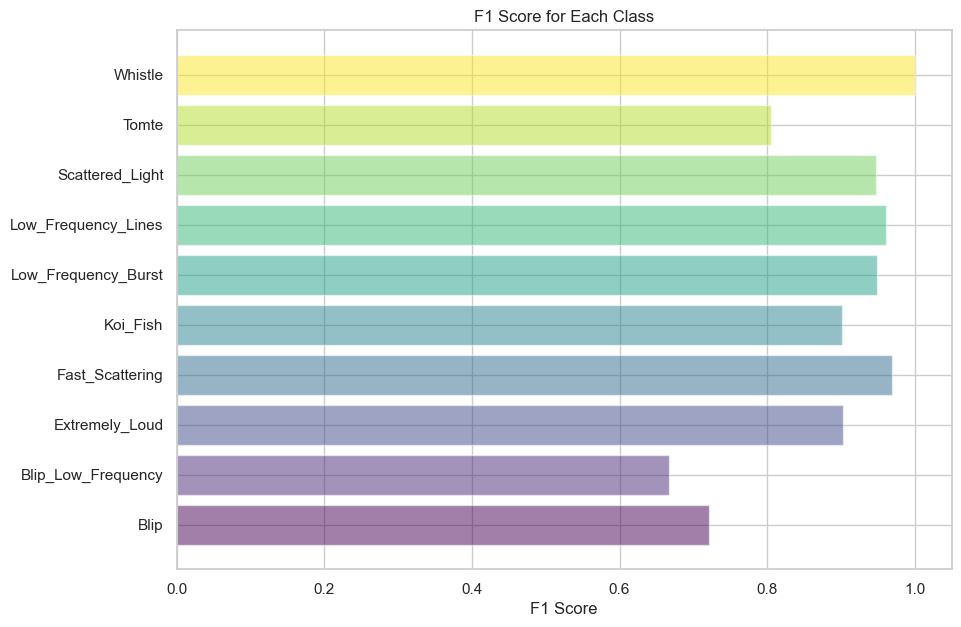

In [30]:
# PLOT F1
my_utils.plot_f1_scores(f1, classes, 'Results/f1_LwF_MultiView_100epochs.png')

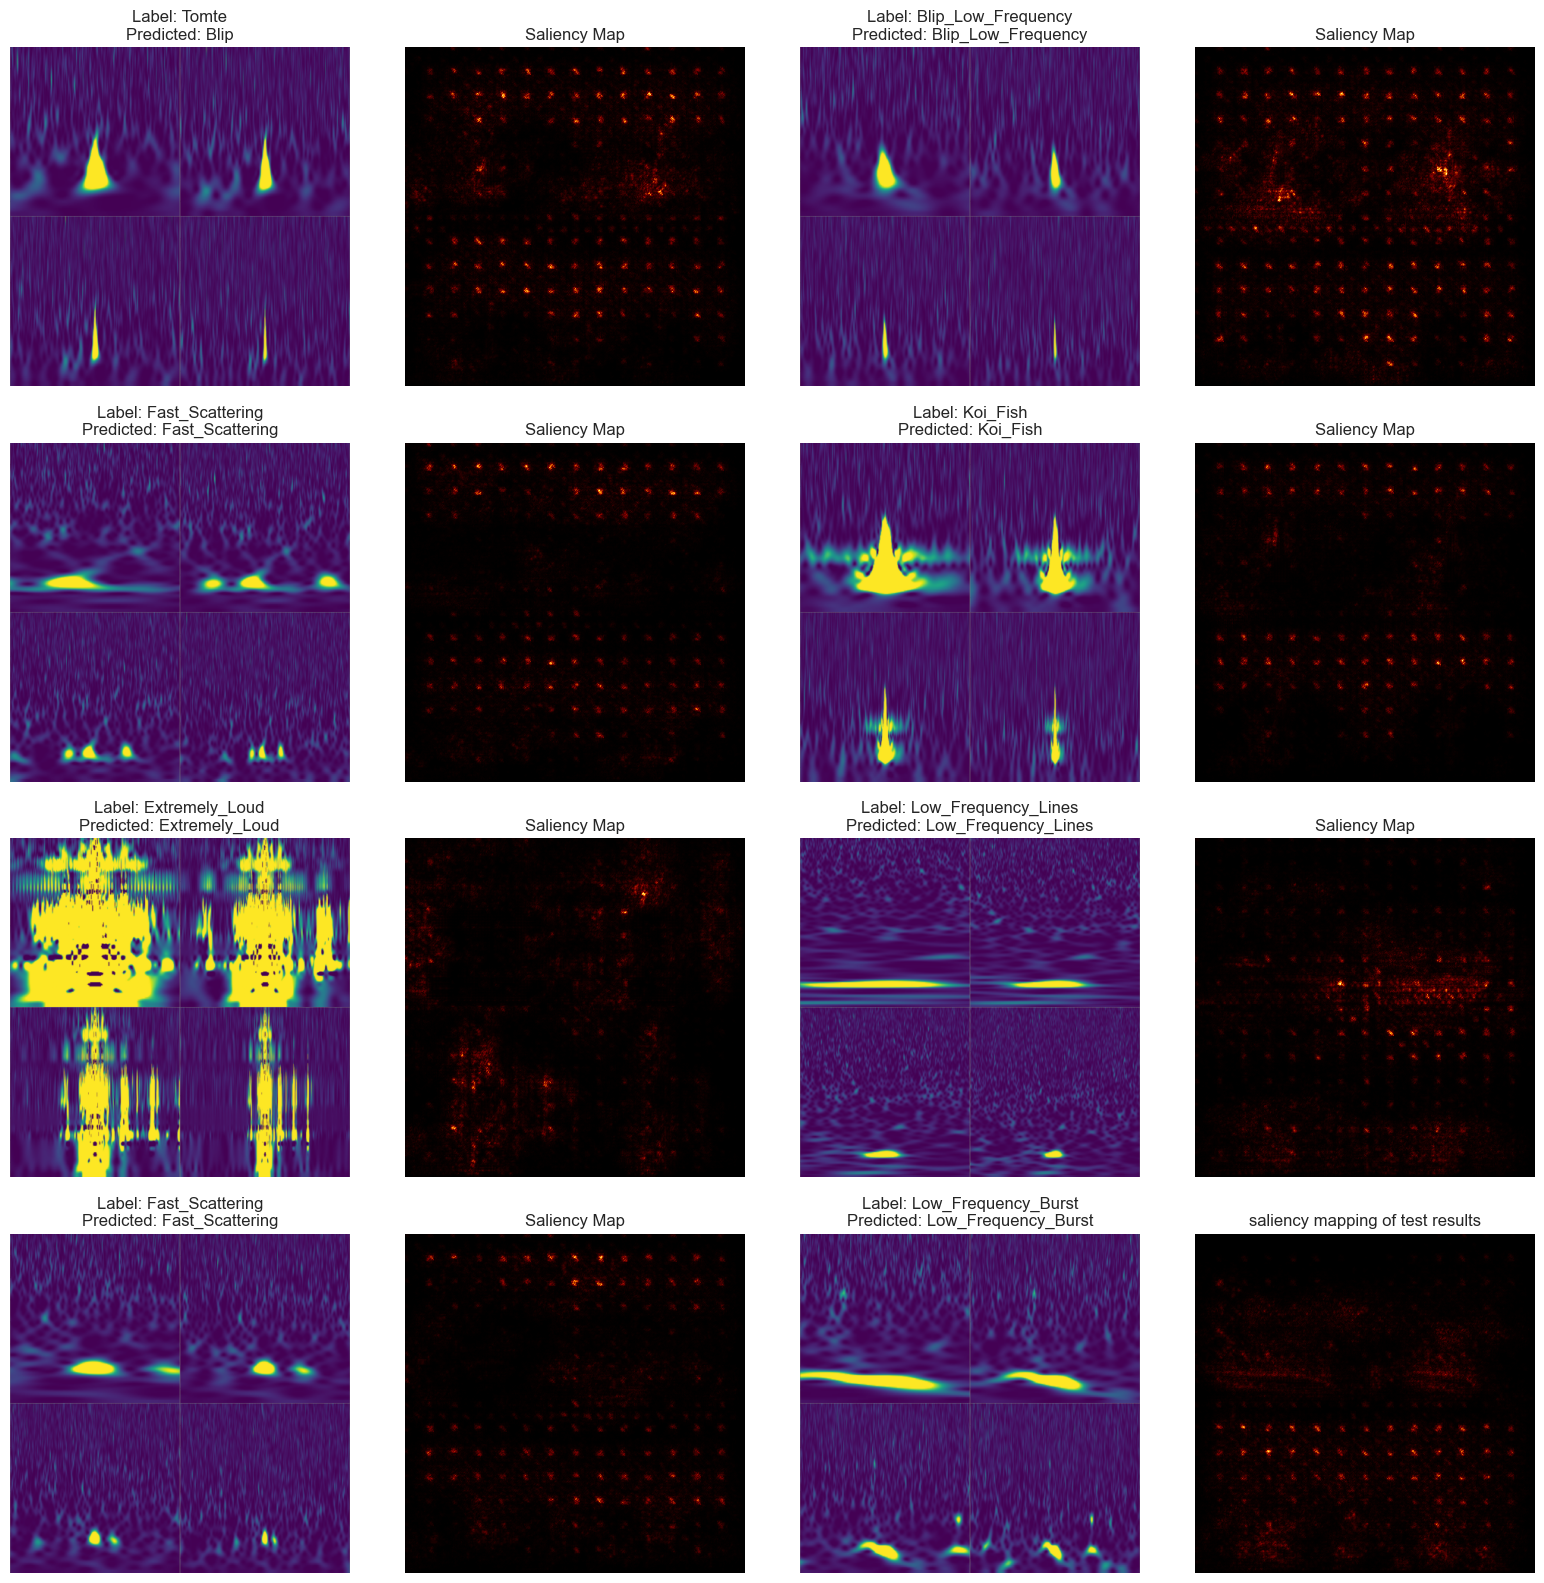

In [31]:
# Initialize a figure to hold the subplots
fig, axs = plt.subplots(4, 4, figsize=(16, 16))

# Get the first batch from the dataloader
model.eval()
i = 0
for image, label in test_loader_av:
    if i < 8:
        # Extract the first image and its label (if available)
        image, label = image.to(device), label.to(device)
        #print(f"Real label = {classes[label]}")
        image.requires_grad_()
        
        # Retrieve output from the image
        output = model(image)
        output_idx = output.argmax(dim=1)
        predicted_label = classes[output_idx.item()]
        #print(f"Predicted label = {predicted_label}")
        
        output_max = output[0, output_idx]
        output_max.backward()
        saliency, _ = torch.max(image.grad.data.abs(), dim=1)
        
        # Plot the original image and its saliency map
        axs[i // 2, i % 2 * 2].imshow(image[0].cpu().detach().numpy().transpose(1, 2, 0))
        axs[i // 2, i % 2 * 2].axis('off')
        axs[i // 2, i % 2 * 2].set_title(f"Label: {classes[label]}\nPredicted: {predicted_label}")
        
        axs[(i // 2), i % 2 * 2 + 1].imshow(saliency[0].cpu().detach().numpy(), cmap='afmhot')
        axs[i // 2, i % 2 * 2 + 1].axis('off')
        axs[i // 2, i % 2 * 2 + 1].set_title("Saliency Map")
        
        i += 1
    else:
        break
plt.title('saliency mapping of test results')
plt.tight_layout()
temp = plt.gcf()
plt.show()
plt.draw()
temp.savefig("Results/SaliencyMapping_LwF_MultiView_100epochs.png")
plt.close()

## Multiview Fusion AGEM model

In [32]:
model = my_architectures.MultiViewColorNet_resnet18(num_classes=10)
model.to(device)

MultiViewColorNet_resnet18(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affi

In [33]:
# log to text file
text_logger = TextLogger(open("multiview_fusion_AGEM_log100_epochs.txt", "a"))
# print to stdout
interactive_logger = InteractiveLogger()
csv_logger = CSVLogger()
classes = my_utils.get_classes_from_dir(train_dir_2)
class_to_indx = my_utils.classes_to_indices(classes)

In [34]:
# OPTIMIZER and CRITERION
optimizer = AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)
criterion = CrossEntropyLoss()

In [35]:
# STRATEGY
cl_strategy = AGEM(
    model=model, optimizer=optimizer, criterion=criterion, patterns_per_exp=10,
    train_mb_size=64, train_epochs=100, eval_mb_size=32, device=device, evaluator=eval_plugin,
    plugins=[ReplayPlugin(mem_size=2*len(train_set)), AGEMPlugin(patterns_per_experience=11, sample_size=64)]
)

Starting experiment with strategy: <avalanche.training.supervised.strategy_wrappers.AGEM object at 0x000001D23A2A79A0>
Start of experience:  0
Current Classes:  [4, 5]
-- >> Start of training phase << --
100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:20<00:00,  2.98s/it]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 1.5902
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.7050
100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:20<00:00,  2.95s/it]
Epoch 1 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.5441
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9975
100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:20<00:00,  2.98s/it]
Epoch 2 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.1298
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9950
100%|██████████████████████████████████████████████████

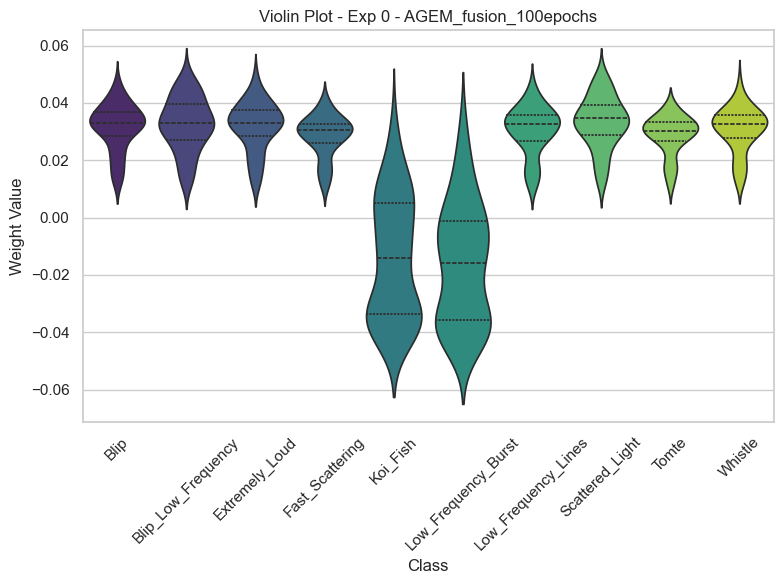

Start of experience:  1
Current Classes:  [8, 2]
-- >> Start of training phase << --
100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:47<00:00,  6.83s/it]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 3.2253
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.4788
100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:46<00:00,  6.68s/it]
Epoch 1 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 1.0794
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.6188
100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:46<00:00,  6.71s/it]
Epoch 2 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.7146
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.6963
100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:46<00:00,  6.68s/it]
Epoch 3 ended.
	Loss_Epoch/train_phase/train_stream/Ta

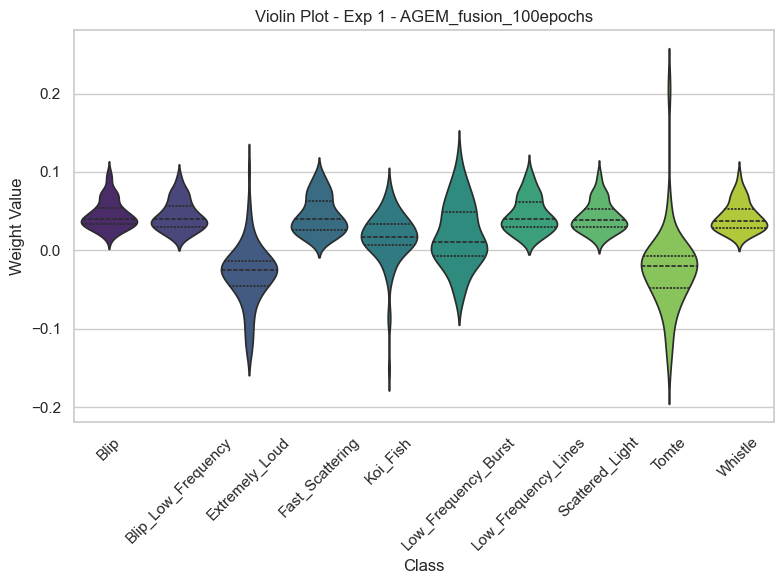

Start of experience:  2
Current Classes:  [9, 6]
-- >> Start of training phase << --
100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:57<00:00,  8.18s/it]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 3.4592
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.4623
100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:56<00:00,  8.09s/it]
Epoch 1 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 1.0327
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.6533
100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:56<00:00,  8.10s/it]
Epoch 2 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.4891
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.8255
100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:56<00:00,  8.11s/it]
Epoch 3 ended.
	Loss_Epoch/train_phase/train_stream/Ta

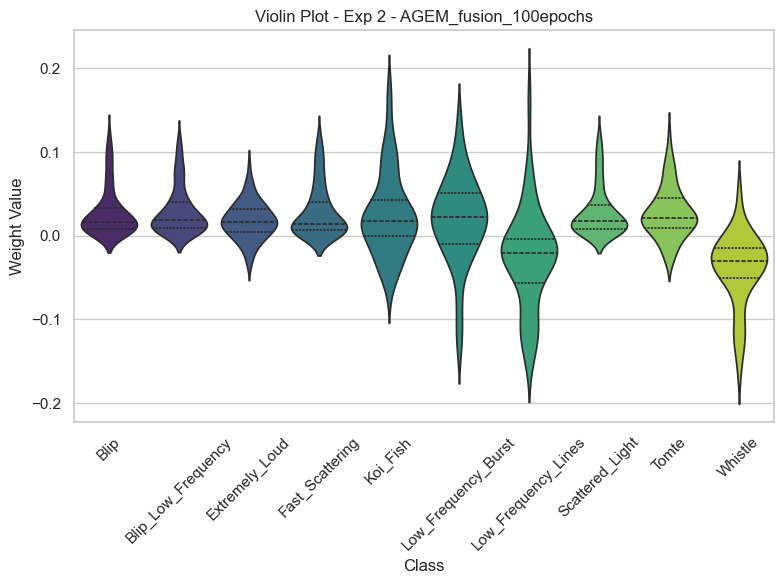

Start of experience:  3
Current Classes:  [1, 7]
-- >> Start of training phase << --
100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:04<00:00,  9.17s/it]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 4.3719
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.4764
100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:03<00:00,  9.06s/it]
Epoch 1 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 1.4511
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.4976
100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:03<00:00,  9.09s/it]
Epoch 2 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.9286
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.7618
100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:03<00:00,  9.05s/it]
Epoch 3 ended.
	Loss_Epoch/train_phase/train_stream/Ta

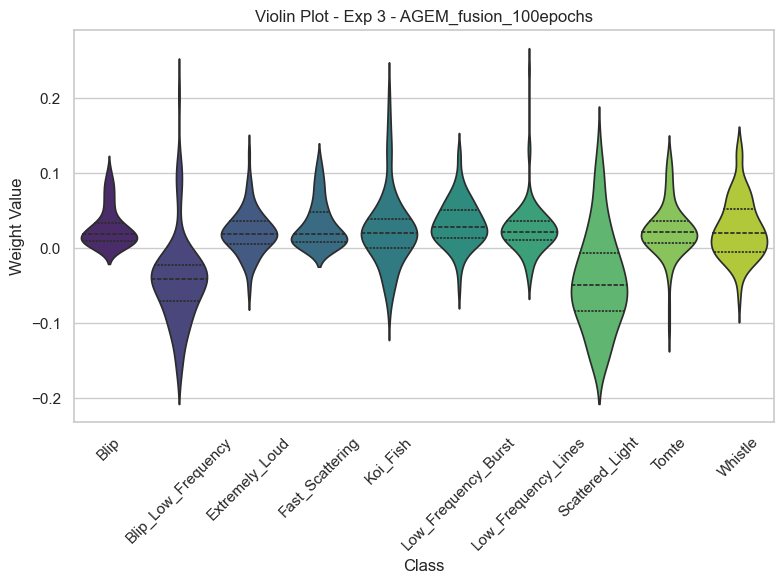

Start of experience:  4
Current Classes:  [0, 3]
-- >> Start of training phase << --
100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:10<00:00, 10.03s/it]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 4.9464
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.4564
100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:09<00:00, 10.00s/it]
Epoch 1 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 1.6619
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.4540
100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:09<00:00,  9.94s/it]
Epoch 2 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 1.4452
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.4410
100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:11<00:00, 10.18s/it]
Epoch 3 ended.
	Loss_Epoch/train_phase/train_stream/Ta

In [ ]:
# TRAINING
results=[]
results = my_utils.cl_simple_train_loop(bm, cl_strategy, model, optimizer, number_of_workers, classes, 'AGEM_fusion_100epochs', scr=False)

In [ ]:
# SAVE MODEL
my_utils.checkpoint(model, 'Models/thesis_MultiView_AGEM_100epochs.pth')

In [ ]:
# CALCULATE ALL PREDICTIONS
test_loader = torch.utils.data.DataLoader(test_set, batch_size=1, shuffle=True)
y_pred_list, y_true_list = my_utils.get_predictions(model, test_loader_av)

In [ ]:
# GENERATE CONFUSION MATRIX AND F1
cm = confusion_matrix(y_true_list, y_pred_list)
f1 = f1_score(y_true_list, y_pred_list, average=None)

In [ ]:
# PLOT CM
my_utils.plot_confusion_matrix(cm, classes, 'Results/cm_AGEM_MultiView_100epochs.png')

In [ ]:
# PLOT t-SNE
my_utils.plot_tSNE_data_embedding(model, train_loader_av, classes, 'Results/tSNE_AGEM_MultiView_100epochs.png')

In [ ]:
my_utils.plot_tSNE_data_embedding(model, test_loader_av, classes, 'Results/tSNE_AGEM_MultiView_testset_100epochs.png')

In [ ]:
# PLOT F1
my_utils.plot_f1_scores(f1, classes, 'Results/f1_AGEM_MultiView_100epochs.png')

In [ ]:
# Initialize a figure to hold the subplots
fig, axs = plt.subplots(4, 4, figsize=(16, 16))

# Get the first batch from the dataloader
model.eval()
i = 0
for image, label in test_loader_av:
    if i < 8:
        # Extract the first image and its label (if available)
        image, label = image.to(device), label.to(device)
        #print(f"Real label = {classes[label]}")
        image.requires_grad_()
        
        # Retrieve output from the image
        output = model(image)
        output_idx = output.argmax(dim=1)
        predicted_label = classes[output_idx.item()]
        #print(f"Predicted label = {predicted_label}")
        
        output_max = output[0, output_idx]
        output_max.backward()
        saliency, _ = torch.max(image.grad.data.abs(), dim=1)
        
        # Plot the original image and its saliency map
        axs[i // 2, i % 2 * 2].imshow(image[0].cpu().detach().numpy().transpose(1, 2, 0))
        axs[i // 2, i % 2 * 2].axis('off')
        axs[i // 2, i % 2 * 2].set_title(f"Label: {classes[label]}\nPredicted: {predicted_label}")
        
        axs[(i // 2), i % 2 * 2 + 1].imshow(saliency[0].cpu().detach().numpy(), cmap='afmhot')
        axs[i // 2, i % 2 * 2 + 1].axis('off')
        axs[i // 2, i % 2 * 2 + 1].set_title("Saliency Map")
        
        i += 1
    else:
        break
plt.title('saliency mapping of test results')
plt.tight_layout()
temp = plt.gcf()
plt.show()
plt.draw()
temp.savefig("Results/SaliencyMapping_AGEM_MultiView_100epochs.png")
plt.close()

## Multiview Fusion EWC model

In [ ]:
model = my_architectures.MultiViewColorNet_resnet18(num_classes=10)
model.to(device)

# log to text file
text_logger = TextLogger(open("multiview_fusion_EWC_log_100epochs.txt", "a"))
# print to stdout
interactive_logger = InteractiveLogger()
csv_logger = CSVLogger()
classes = my_utils.get_classes_from_dir(train_dir_2)
class_to_indx = my_utils.classes_to_indices(classes)

# OPTIMIZER and CRITERION
optimizer = AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)
criterion = CrossEntropyLoss()

In [ ]:
# STRATEGY
cl_strategy = EWC(
    model=model, optimizer=optimizer, criterion=criterion, ewc_lambda=0.1,
    train_mb_size=64, train_epochs=100, eval_mb_size=32, device=device, evaluator=eval_plugin,
    plugins=[ReplayPlugin(mem_size=2*len(train_set))]
)

In [ ]:
# TRAINING
results=[]
results = my_utils.cl_simple_train_loop(bm, cl_strategy, model, optimizer, number_of_workers, classes, 'EWC_fusion_100epochs', scr=False)

In [ ]:
# SAVE MODEL
my_utils.checkpoint(model, 'Models/thesis_MultiView_EWC_100epochs.pth')

In [ ]:
# CALCULATE ALL PREDICTIONS
test_loader = torch.utils.data.DataLoader(test_set, batch_size=1, shuffle=True)
y_pred_list, y_true_list = my_utils.get_predictions(model, test_loader_av)

In [ ]:
# GENERATE CONFUSION MATRIX AND F1
cm = confusion_matrix(y_true_list, y_pred_list)
f1 = f1_score(y_true_list, y_pred_list, average=None)

In [ ]:
# PLOT CM
my_utils.plot_confusion_matrix(cm, classes, 'Results/cm_EWC_MultiView_100epochs.png')

In [ ]:
# PLOT t-SNE
my_utils.plot_tSNE_data_embedding(model, train_loader_av, classes, 'Results/tSNE_EWC_MultiView_100epochs.png')

In [ ]:
my_utils.plot_tSNE_data_embedding(model, test_loader_av, classes, 'Results/tSNE_EWC_MultiView_testset_100epochs.png')

In [ ]:
# PLOT F1
my_utils.plot_f1_scores(f1, classes, 'Results/f1_EWC_MultiView_100epochs.png')

In [ ]:
# Initialize a figure to hold the subplots
fig, axs = plt.subplots(4, 4, figsize=(16, 16))

# Get the first batch from the dataloader
model.eval()
i = 0
for image, label in test_loader_av:
    if i < 8:
        # Extract the first image and its label (if available)
        image, label = image.to(device), label.to(device)
        #print(f"Real label = {classes[label]}")
        image.requires_grad_()
        
        # Retrieve output from the image
        output = model(image)
        output_idx = output.argmax(dim=1)
        predicted_label = classes[output_idx.item()]
        #print(f"Predicted label = {predicted_label}")
        
        output_max = output[0, output_idx]
        output_max.backward()
        saliency, _ = torch.max(image.grad.data.abs(), dim=1)
        
        # Plot the original image and its saliency map
        axs[i // 2, i % 2 * 2].imshow(image[0].cpu().detach().numpy().transpose(1, 2, 0))
        axs[i // 2, i % 2 * 2].axis('off')
        axs[i // 2, i % 2 * 2].set_title(f"Label: {classes[label]}\nPredicted: {predicted_label}")
        
        axs[(i // 2), i % 2 * 2 + 1].imshow(saliency[0].cpu().detach().numpy(), cmap='afmhot')
        axs[i // 2, i % 2 * 2 + 1].axis('off')
        axs[i // 2, i % 2 * 2 + 1].set_title("Saliency Map")
        
        i += 1
    else:
        break
plt.title('saliency mapping of test results')
plt.tight_layout()
temp = plt.gcf()
plt.show()
plt.draw()
temp.savefig("Results/SaliencyMapping_EWC_MultiView_100epochs.png")
plt.close()

## Multiview Fusion DER model

In [ ]:
model = my_architectures.MultiViewColorNet_resnet18(num_classes=10)
model.to(device)

# log to text file
text_logger = TextLogger(open("multiview_fusion_DER_log_100epochs.txt", "a"))
# print to stdout
interactive_logger = InteractiveLogger()
csv_logger = CSVLogger()
classes = my_utils.get_classes_from_dir(train_dir_2)
class_to_indx = my_utils.classes_to_indices(classes)

# OPTIMIZER and CRITERION
optimizer = AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)
criterion = CrossEntropyLoss()

In [ ]:
# STRATEGY
cl_strategy = DER(
    model=model, optimizer=optimizer, criterion=criterion, alpha=1.0, beta=0, mem_size=500,
    train_mb_size=64, train_epochs=100, eval_mb_size=32, device=device, evaluator=eval_plugin,
    #plugins=[ReplayPlugin(mem_size=2*len(train_set))]
)

In [ ]:
# TRAINING
results=[]
results = my_utils.cl_simple_train_loop(bm, cl_strategy, model, optimizer, number_of_workers, classes, 'DER_fusion_100epochs', scr=False)

In [ ]:
# SAVE MODEL
my_utils.checkpoint(model, 'Models/thesis_MultiView_DER_100epochs.pth')

In [ ]:
# CALCULATE ALL PREDICTIONS
test_loader = torch.utils.data.DataLoader(test_set, batch_size=1, shuffle=True)
y_pred_list, y_true_list = my_utils.get_predictions(model, test_loader_av)

In [ ]:
# GENERATE CONFUSION MATRIX AND F1
cm = confusion_matrix(y_true_list, y_pred_list)
f1 = f1_score(y_true_list, y_pred_list, average=None)

In [ ]:
# PLOT CM
my_utils.plot_confusion_matrix(cm, classes, 'Results/cm_DER_MultiView_100epochs.png')

In [ ]:
# PLOT t-SNE
my_utils.plot_tSNE_data_embedding(model, train_loader_av, classes, 'Results/tSNE_DER_MultiView_100epochs.png')

In [ ]:
my_utils.plot_tSNE_data_embedding(model, test_loader_av, classes, 'Results/tSNE_DER_MultiView_testset_100epochs.png')

In [ ]:
# PLOT F1
my_utils.plot_f1_scores(f1, classes, 'Results/f1_DER_MultiView_100epochs.png')

In [ ]:
# Initialize a figure to hold the subplots
fig, axs = plt.subplots(4, 4, figsize=(16, 16))

# Get the first batch from the dataloader
model.eval()
i = 0
for image, label in test_loader_av:
    if i < 8:
        # Extract the first image and its label (if available)
        image, label = image.to(device), label.to(device)
        #print(f"Real label = {classes[label]}")
        image.requires_grad_()
        
        # Retrieve output from the image
        output = model(image)
        output_idx = output.argmax(dim=1)
        predicted_label = classes[output_idx.item()]
        #print(f"Predicted label = {predicted_label}")
        
        output_max = output[0, output_idx]
        output_max.backward()
        saliency, _ = torch.max(image.grad.data.abs(), dim=1)
        
        # Plot the original image and its saliency map
        axs[i // 2, i % 2 * 2].imshow(image[0].cpu().detach().numpy().transpose(1, 2, 0))
        axs[i // 2, i % 2 * 2].axis('off')
        axs[i // 2, i % 2 * 2].set_title(f"Label: {classes[label]}\nPredicted: {predicted_label}")
        
        axs[(i // 2), i % 2 * 2 + 1].imshow(saliency[0].cpu().detach().numpy(), cmap='afmhot')
        axs[i // 2, i % 2 * 2 + 1].axis('off')
        axs[i // 2, i % 2 * 2 + 1].set_title("Saliency Map")
        
        i += 1
    else:
        break
plt.title('saliency mapping of test results')
plt.tight_layout()
temp = plt.gcf()
plt.show()
plt.draw()
temp.savefig("Results/SaliencyMapping_DER_MultiView_100epochs.png")
plt.close()

## Multiview Fusion DER++ model

In [ ]:
model = my_architectures.MultiViewColorNet_resnet18(num_classes=10)
model.to(device)

# log to text file
text_logger = TextLogger(open("multiview_fusion_DER++_log_100epochs.txt", "a"))
# print to stdout
interactive_logger = InteractiveLogger()
csv_logger = CSVLogger()
classes = my_utils.get_classes_from_dir(train_dir_2)
class_to_indx = my_utils.classes_to_indices(classes)

# OPTIMIZER and CRITERION
optimizer = AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)
criterion = CrossEntropyLoss()

In [ ]:
# STRATEGY
## DER++ is adding a beta factor > 0
cl_strategy = DER(
    model=model, optimizer=optimizer, criterion=criterion, alpha=0.5, beta=1.0, mem_size=500,
    train_mb_size=64, train_epochs=100, eval_mb_size=32, device=device, evaluator=eval_plugin,
    #plugins=[ReplayPlugin(mem_size=2*len(train_set))]
)

In [ ]:
# TRAINING
results=[]
results = my_utils.cl_simple_train_loop(bm, cl_strategy, model, optimizer, number_of_workers, classes, 'DER++_fusion_100epochs', scr=False)

In [ ]:
# SAVE MODEL
my_utils.checkpoint(model, 'Models/thesis_MultiView_DER++_100epochs.pth')

In [ ]:
# CALCULATE ALL PREDICTIONS
test_loader = torch.utils.data.DataLoader(test_set, batch_size=1, shuffle=True)
y_pred_list, y_true_list = my_utils.get_predictions(model, test_loader_av)

In [ ]:
# GENERATE CONFUSION MATRIX AND F1
cm = confusion_matrix(y_true_list, y_pred_list)
f1 = f1_score(y_true_list, y_pred_list, average=None)

In [ ]:
# PLOT CM
my_utils.plot_confusion_matrix(cm, classes, 'Results/cm_DER++_MultiView_100epochs.png')

In [ ]:
# PLOT t-SNE
my_utils.plot_tSNE_data_embedding(model, train_loader_av, classes, 'Results/tSNE_DER++_MultiView_100epochs.png')

In [ ]:
my_utils.plot_tSNE_data_embedding(model, test_loader_av, classes, 'Results/tSNE_DER++_MultiView_testset_100epochs.png')

In [ ]:
# PLOT F1
my_utils.plot_f1_scores(f1, classes, 'Results/f1_DER++_MultiView_100epochs.png')

In [ ]:
# Initialize a figure to hold the subplots
fig, axs = plt.subplots(4, 4, figsize=(16, 16))

# Get the first batch from the dataloader
model.eval()
i = 0
for image, label in test_loader_av:
    if i < 8:
        # Extract the first image and its label (if available)
        image, label = image.to(device), label.to(device)
        #print(f"Real label = {classes[label]}")
        image.requires_grad_()
        
        # Retrieve output from the image
        output = model(image)
        output_idx = output.argmax(dim=1)
        predicted_label = classes[output_idx.item()]
        #print(f"Predicted label = {predicted_label}")
        
        output_max = output[0, output_idx]
        output_max.backward()
        saliency, _ = torch.max(image.grad.data.abs(), dim=1)
        
        # Plot the original image and its saliency map
        axs[i // 2, i % 2 * 2].imshow(image[0].cpu().detach().numpy().transpose(1, 2, 0))
        axs[i // 2, i % 2 * 2].axis('off')
        axs[i // 2, i % 2 * 2].set_title(f"Label: {classes[label]}\nPredicted: {predicted_label}")
        
        axs[(i // 2), i % 2 * 2 + 1].imshow(saliency[0].cpu().detach().numpy(), cmap='afmhot')
        axs[i // 2, i % 2 * 2 + 1].axis('off')
        axs[i // 2, i % 2 * 2 + 1].set_title("Saliency Map")
        
        i += 1
    else:
        break
plt.title('Saliency Map')
plt.tight_layout()
temp = plt.gcf()
plt.show()
plt.draw()
temp.savefig("Results/SaliencyMapping_DER++_MultiView_100epochs.png")
plt.close()

# TASK INCREMENTAL - Instance based

## Naive

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = my_architectures.MultiViewColorNet_resnet18(num_classes=10)
model.to(device)
# log to text file
text_logger = TextLogger(open("multiview_fusion_TaskBased_log.txt", "a"))
# print to stdout
interactive_logger = InteractiveLogger()
csv_logger = CSVLogger()
classes = my_utils.get_classes_from_dir(train_dir_2)
class_to_indx = my_utils.classes_to_indices(classes)

In [ ]:
bm = ni_benchmark(
    train_dataset=train_set_av,
    test_dataset=val_set_av,
    n_experiences=5,
    shuffle=True,
    seed=1234,
    task_labels=False,
)

In [ ]:
eval_plugin = EvaluationPlugin(
    accuracy_metrics(minibatch=False, epoch=True, experience=True, stream=True),
    loss_metrics(minibatch=False, epoch=True, experience=True, stream=True),
    forgetting_metrics(experience=False, stream=True),
    ram_usage_metrics(experience=True, stream=True, epoch=False),
    bwt_metrics(experience=True, stream=True),
    loggers=[interactive_logger, text_logger, csv_logger],
    strict_checks=False,
)

In [ ]:
# OPTIMIZER and CRITERION
optimizer = AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)
criterion = CrossEntropyLoss(label_smoothing=0.2)

In [ ]:
# NAIVE STRATEGY
cl_strategy = Naive(
    model=model, optimizer=optimizer, criterion=criterion, train_mb_size=32, train_epochs=50, 
    eval_mb_size=16, device=device, evaluator=eval_plugin, 
    plugins=[ReplayPlugin(mem_size=2*len(train_set)), EarlyStoppingPlugin(patience=2, val_stream_name='valid')]
)

In [ ]:
# TRAINING
results=[]
results = my_utils.cl_simple_train_loop(bm, cl_strategy, model, optimizer, number_of_workers, classes, 'TaskBased_Naive_MultiView', scr=False)

In [ ]:
# SAVE MODEL
my_utils.checkpoint(model, 'Models/thesis_TaskBased_Naive_MultiView.pth')

In [ ]:
# LOAD MODEL
temp = torch.load('Models/thesis_TaskBased_Naive_MultiView.pth', map_location=torch.device(device))
model.load_state_dict(temp)

In [ ]:
# CALCULATE ALL PREDICTIONS
test_loader = torch.utils.data.DataLoader(test_set, batch_size=1, shuffle=True)
y_pred_list, y_true_list = my_utils.get_predictions(model, test_loader_av)

In [ ]:
# GENERATE CONFUSION MATRIX AND F1
cm = confusion_matrix(y_true_list, y_pred_list)
f1 = f1_score(y_true_list, y_pred_list, average=None)

In [ ]:
# PLOT CM
my_utils.plot_confusion_matrix(cm, classes, 'Results/cm_TaskBased_Naive_MultiView.png')

In [ ]:
# PLOT F1
my_utils.plot_f1_scores(f1, classes, 'Results/f1_TaskBased_Naive_MultiView.png')

In [ ]:
# PLOT t-SNE
my_utils.plot_tSNE_data_embedding(model, test_loader_av, classes, 'Results/tSNE_taskBased__Naive_MultiView_testset.png')

In [ ]:
# SALIENCY MAP PLOT EXPERIMENT
# Get the first batch from the dataloader
model.eval()
i = 0
for image, label in test_loader_av:
    if i < 16:
        # Extract the first image and its label (if available)
        image, label = image.to(device), label.to(device)
        print(f"Real label = {classes[label]}")
        image.requires_grad_()
        # retrieve output from image 
        output = model(image)
        output_idx = output.argmax(dim=1)
        predicted_label = classes[output_idx.item()]
        print(f"Predicted label = {predicted_label}")
        output_max = output[0, output_idx]
        output_max.backward()
        saliency, _ = torch.max(image.grad.data.abs(), dim=1)
        fig, ax = plt.subplots(1, 2)
        ax[0].imshow(image[0].cpu().detach().numpy().transpose(1, 2, 0))
        ax[0].axis('off')
        ax[1].imshow(saliency[0].cpu().detach().numpy(), cmap='hot')
        ax[1].axis('off')
        plt.tight_layout()
        plt.show()
        i=i+1
    else:
        break

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Initialize a figure to hold the subplots
fig, axs = plt.subplots(4, 4, figsize=(16, 16))

# Get the first batch from the dataloader
model.eval()
i = 0
for image, label in test_loader_av:
    if i < 8:
        # Extract the first image and its label (if available)
        image, label = image.to(device), label.to(device)
        #print(f"Real label = {classes[label]}")
        image.requires_grad_()
        
        # Retrieve output from the image
        output = model(image)
        output_idx = output.argmax(dim=1)
        predicted_label = classes[output_idx.item()]
        #print(f"Predicted label = {predicted_label}")
        
        output_max = output[0, output_idx]
        output_max.backward()
        saliency, _ = torch.max(image.grad.data.abs(), dim=1)
        
        # Plot the original image and its saliency map
        axs[i // 2, i % 2 * 2].imshow(image[0].cpu().detach().numpy().transpose(1, 2, 0))
        axs[i // 2, i % 2 * 2].axis('off')
        axs[i // 2, i % 2 * 2].set_title(f"Label: {classes[label]}\nPredicted: {predicted_label}")
        
        axs[(i // 2), i % 2 * 2 + 1].imshow(saliency[0].cpu().detach().numpy(), cmap='afmhot')
        axs[i // 2, i % 2 * 2 + 1].axis('off')
        axs[i // 2, i % 2 * 2 + 1].set_title("Saliency Map")
        
        i += 1
    else:
        break
plt.title('saliency mapping of test results')
plt.tight_layout()
temp = plt.gcf()
plt.show()
plt.draw()
temp.savefig("Results/saliency_mapping_taskBased__Naive_MultiView_testset.png")
plt.close()

## SCR

In [ ]:
from avalanche.training import SCR, SCRLoss
from avalanche.models import SCRModel
resnet18 = my_architectures.MultiViewColorNet_resnet18(num_classes=10)
resnet18.to(device)
projection_network = nn.Linear(10, 512)  # Adjust the output size as needed
projection_network.to(device)
scr_model = SCRModel(feature_extractor=resnet18, projection=projection_network)
optimizer = SGD(model.parameters(), lr=0.001, weight_decay=1e-5) #although in the paper lr = 0.1 initially
criterion = CrossEntropyLoss(label_smoothing=0.2)
scr_model.to(device)

In [ ]:
eval_plugin = EvaluationPlugin(
    accuracy_metrics(minibatch=False, epoch=False, experience=True, stream=True),
    loss_metrics(minibatch=False, epoch=False, experience=True, stream=True),
    #forgetting_metrics(experience=False, stream=True),
    #bwt_metrics(experience=True, stream=True),
    #forward_transfer_metrics(experience=True, stream=True),
    loggers=[InteractiveLogger()],
    strict_checks=False,
)

In [ ]:
# SCR STRATEGY
cl_strategy = SCR(
    model=scr_model, optimizer=optimizer, criterion=criterion, train_mb_size=32, train_epochs=50, 
    eval_mb_size=16, mem_size=1000, temperature=0.1, device=device, evaluator=eval_plugin
)

In [ ]:
# TRAINING
results=[]
results = my_utils.cl_simple_train_loop(bm, cl_strategy, scr_model, optimizer, number_of_workers, classes, 'TaskBased_Contrastive_MultiView', scr=True)

In [ ]:
# SAVE MODEL
my_utils.checkpoint(scr_model, 'Models/thesis_TaskBased_Contrastive_MultiView.pth')

In [ ]:
# LOAD MODEL
temp = torch.load('Models/thesis_TaskBased_Contrastive_MultiView.pth', map_location=torch.device(device))
scr_model.load_state_dict(temp)

In [ ]:
# CALCULATE ALL PREDICTIONS
test_loader = torch.utils.data.DataLoader(test_set, batch_size=1, shuffle=True)
y_pred_list, y_true_list = my_utils.get_predictions(scr_model, test_loader_av)

In [ ]:
# GENERATE CONFUSION MATRIX AND F1
cm = confusion_matrix(y_true_list, y_pred_list)
f1 = f1_score(y_true_list, y_pred_list, average=None)

In [ ]:
# PLOT CM
my_utils.plot_confusion_matrix(cm, classes, 'Results/cm_TaskBased_Contrastive_MultiView.png')

In [ ]:
# PLOT F1
my_utils.plot_f1_scores(f1, classes, 'Results/f1_TaskBased_Contrastive_MultiView.png')

In [ ]:
# PLOT t-SNE
my_utils.plot_tSNE_data_embedding(scr_model, train_loader_av, classes, 'Results/tSNE_Contrastive_MultiView.png')

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Initialize a figure to hold the subplots
fig, axs = plt.subplots(4, 4, figsize=(16, 16))

# Get the first batch from the dataloader
model.eval()
i = 0
for image, label in test_loader_av:
    if i < 8:
        # Extract the first image and its label (if available)
        image, label = image.to(device), label.to(device)
        #print(f"Real label = {classes[label]}")
        image.requires_grad_()
        
        # Retrieve output from the image
        output = model(image)
        output_idx = output.argmax(dim=1)
        predicted_label = classes[output_idx.item()]
        #print(f"Predicted label = {predicted_label}")
        
        output_max = output[0, output_idx]
        output_max.backward()
        saliency, _ = torch.max(image.grad.data.abs(), dim=1)
        
        # Plot the original image and its saliency map
        axs[i // 2, i % 2 * 2].imshow(image[0].cpu().detach().numpy().transpose(1, 2, 0))
        axs[i // 2, i % 2 * 2].axis('off')
        axs[i // 2, i % 2 * 2].set_title(f"Label: {classes[label]}\nPredicted: {predicted_label}")
        
        axs[(i // 2), i % 2 * 2 + 1].imshow(saliency[0].cpu().detach().numpy(), cmap='afmhot')
        axs[i // 2, i % 2 * 2 + 1].axis('off')
        axs[i // 2, i % 2 * 2 + 1].set_title("Saliency Map")
        
        i += 1
    else:
        break
plt.title('saliency mapping of test results')
plt.tight_layout()
temp = plt.gcf()
plt.show()
plt.draw()
temp.savefig("Results/SaliencyMapping_TaskBased_Contrastive_MultiView.png")
plt.close()

## SCR second training

In [ ]:
train_set = my_dataloaders.MultiViewGravitySpyDataset(root=train_dir_2, cls=classes, transform=my_transformations.transformAV_Fuse_448_Crop)
val_set = my_dataloaders.MultiViewGravitySpyDataset(root=val_dir, cls=classes, transform=my_transformations.transformAV_448_Fuse)
test_set = my_dataloaders.MultiViewGravitySpyDataset(root=test_dir, cls=classes, transform=my_transformations.transformAV_448_Fuse)

train_set_av = AvalancheDataset(train_set)
train_loader_av = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True, num_workers=number_of_workers)

val_set_av = AvalancheDataset(val_set)
val_loader_av = torch.utils.data.DataLoader(val_set, batch_size=32, shuffle=True, num_workers=number_of_workers)

test_set_av = AvalancheDataset(test_set)
test_loader_av = torch.utils.data.DataLoader(test_set, batch_size=1, shuffle=True)

train_set_av.targets = [label for i, label in enumerate(train_set.labels) if i % 4 == 0]
test_set_av.targets = [label for i, label in enumerate(test_set.labels) if i % 4 == 0]
val_set_av.targets = [label for i, label in enumerate(val_set.labels) if i % 4 == 0]

train_set_av.uniques = list(set(train_set.labels))
test_set_av.uniques = list(set(test_set.labels))
val_set_av.uniques = list(set(val_set.labels))

# DEFINE THE BENCHMARK
# CL custom benchmark, here we opt for the generator New Instances (NI)
# Given a sequence of train and test datasets this creates the continual stream as a series of experiences.
bm = ni_benchmark(
    train_dataset=train_set_av,
    test_dataset=val_set_av,
    n_experiences=5,
    shuffle=True,
    seed=1234,
    task_labels=False,
)

In [ ]:
# second online TRAINING
results=[]
results = my_utils.cl_simple_train_loop(bm, cl_strategy, scr_model, optimizer, number_of_workers, classes, 'TaskBased_Contrastive_2NDTR_MultiView', scr=True)

In [ ]:
# CALCULATE ALL PREDICTIONS
test_loader = torch.utils.data.DataLoader(test_set, batch_size=1, shuffle=True)
y_pred_list, y_true_list = my_utils.get_predictions(scr_model, test_loader_av)

In [ ]:
# GENERATE CONFUSION MATRIX AND F1
cm = confusion_matrix(y_true_list, y_pred_list)
f1 = f1_score(y_true_list, y_pred_list, average=None)

In [ ]:
# SAVE MODEL
my_utils.checkpoint(scr_model, 'Models/thesis_TaskBased_Contrastive_2NDTR_MultiView.pth')

In [ ]:
# PLOT CM
my_utils.plot_confusion_matrix(cm, classes, 'Results/cm_TaskBased_Contrastive_2NDTR_MultiView.png')

In [ ]:
# PLOT F1
my_utils.plot_f1_scores(f1, classes, 'Results/f1_TaskBased_Contrastive_2NDTR_MultiView.png')

In [ ]:
my_utils.plot_tSNE_data_embedding(scr_model, train_loader_av, classes, 'Results/tSNE_TaskBased_Contrastive_2NDTR_MultiView.png')

In [ ]:
my_utils.plot_tSNE_data_embedding(scr_model, test_loader_av, classes, 'Results/tSNE_TaskBased_Contrastive_2NDTR_MultiView_testset.png')

In [ ]:
# Initialize a figure to hold the subplots
fig, axs = plt.subplots(4, 4, figsize=(16, 16))

# Get the first batch from the dataloader
model.eval()
i = 0
for image, label in test_loader_av:
    if i < 8:
        # Extract the first image and its label (if available)
        image, label = image.to(device), label.to(device)
        #print(f"Real label = {classes[label]}")
        image.requires_grad_()
        
        # Retrieve output from the image
        output = model(image)
        output_idx = output.argmax(dim=1)
        predicted_label = classes[output_idx.item()]
        #print(f"Predicted label = {predicted_label}")
        
        output_max = output[0, output_idx]
        output_max.backward()
        saliency, _ = torch.max(image.grad.data.abs(), dim=1)
        
        # Plot the original image and its saliency map
        axs[i // 2, i % 2 * 2].imshow(image[0].cpu().detach().numpy().transpose(1, 2, 0))
        axs[i // 2, i % 2 * 2].axis('off')
        axs[i // 2, i % 2 * 2].set_title(f"Label: {classes[label]}\nPredicted: {predicted_label}")
        
        axs[(i // 2), i % 2 * 2 + 1].imshow(saliency[0].cpu().detach().numpy(), cmap='afmhot')
        axs[i // 2, i % 2 * 2 + 1].axis('off')
        axs[i // 2, i % 2 * 2 + 1].set_title("Saliency Map")
        
        i += 1
    else:
        break
plt.title('saliency mapping of test results')
plt.tight_layout()
temp = plt.gcf()
plt.show()
plt.draw()
temp.savefig("Results/SaliencyMapping_TaskBased_Contrastive_2NDTR_MultiView.png")
plt.close()